<H1><center> Final Project - Biostat 821 </center></H1> 
<H3><center> Joaquin Menendez (jm622) </center></H3>  <hr>

**1.** In Component [2] Task 2.A, I developed a script that conditionally decompressed the database and moved it to a new location.
Next is a demonstration of how this script works.
We start exploring the current working directory (in this case is the container data volume)

In [1]:
!ls

analysis.py	   BIOS821_Final_Project.pdf  docker  Pipeline.ipynb
augmented_data.py  decompress_soccer_v2.sh    mapbox  README.md


The script `decompress_soccer_vs.sh` takes 4 arguments (been only the first two mandatory).
Rhe script download the European Soccer dataset from Kaggle (kaggle.com/hugomathien/soccer).
The function assumes that the user has setted their Kagle's username and key  as enviroment variables . For a detailed instrucion of how to get this information and set the enviroment variables check the [README](https://gitlab.oit.duke.edu/jm622/bio821/blob/master/README.md). 
 
 
  - 1 argument : str [Name/path of the dataset]
  - 2 argument: str [Name/path of the md5 file]
  - 3 argument(optative) : str [Move the dataset to a existing folder (i.e.  './data')]
  - 4 argument(optative) : str "d" [Decompress the file.It will decompress the file into the new location (arg 3)]

In [2]:
!mkdir data
!bash decompress_soccer_v2.sh soccer.zip esdb.md5 data d

100%|██████████████████████████████████████| 32.7M/32.7M [00:01<00:00, 25.3MB/s]
100%|██████████████████████████████████████| 32.7M/32.7M [00:01<00:00, 24.5MB/s]
mv: 'soccer.zip' and 'soccer.zip' are the same file
--2019-12-09 01:55:56--  https://gitlab.oit.duke.edu/bios821/european_soccer_database/raw/master/esdb.md5
Resolving gitlab.oit.duke.edu (gitlab.oit.duke.edu)... 152.3.100.48
Connecting to gitlab.oit.duke.edu (gitlab.oit.duke.edu)|152.3.100.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45 [text/plain]
Saving to: ‘esdb.md5’

esdb.md5            100%[===================>]      45  --.-KB/s    in 0s      

2019-12-09 01:55:57 (840 KB/s) - ‘esdb.md5’ saved [45/45]

Hash file and md5 hash match (bb8c8ab9ca96931688ccf0ea2d21cfc9 | bb8c8ab9ca96931688ccf0ea2d21cfc9)
Archive:  soccer.zip
  inflating: database.sqlite         


We can observe that the database was downloaded and moved to the direcory `data` where it was decompressed.

In [3]:
!ls data

database.sqlite  soccer.zip


Let's create a new directory in order to see how the user could select any folder he wants to move the file if the file hash and the md5 hash is the same. In this opportunity we are **not** going to decompress the file. Observe how the script detect the existence of a `esdb.md5` file and therefore it does not download it again.

In [4]:
!mkdir data_v2

In [5]:
!bash decompress_soccer_v2.sh a_new_soccer_file.zip esdb.md5 data_v2 

 98%|█████████████████████████████████████▏| 32.0M/32.7M [00:01<00:00, 25.4MB/s]
100%|██████████████████████████████████████| 32.7M/32.7M [00:01<00:00, 25.1MB/s]
The MD5 file already exist
Hash file and md5 hash match (bb8c8ab9ca96931688ccf0ea2d21cfc9 | bb8c8ab9ca96931688ccf0ea2d21cfc9)


In [6]:
!ls data_v2

a_new_soccer_file.zip


The script also prevent to download the database if the file already exist

In [7]:
!bash decompress_soccer_v2.sh data_v2/a_new_soccer_file.zip esdb.md5

The dataset already exist
The MD5 file already exist
Hash file and md5 hash match (bb8c8ab9ca96931688ccf0ea2d21cfc9 | bb8c8ab9ca96931688ccf0ea2d21cfc9)


---

**2.** In Task 2.B I made a script to augment the data by geocoding every country latitude and longitude. 
In task 3.2.3 I packeged the same functionality using a python package `mapbox`. <br>
Let's see both cases.

#### Imperative way

In [8]:
import pandas as pd
import requests
import sqlalchemy
import os

df = pd.read_sql_table('Country','sqlite:///data/database.sqlite')
countries = df['name'].unique() # unique countries

public_token = "pk.eyJ1IjoibWVsbGlqb2FjbyIsImEiOiJjazNwNTc3a2YyOGp1M2RsZHNmcXIwdG5nIn0.hCauisNqiuFuVAnwiH7AQA"
private_token = os.environ['MAPBOX_PRIVATE_TOKEN'] # check this in the future

all_countries = {}
# there is a problem. MAPBOX do not consider countries inside UK as countries. It assigns the 'region' id.

for country in countries:
    query = "https://api.mapbox.com/geocoding/v5/mapbox.places/{}.json?types=country,region&access_token=".format(country) + private_token
    data = requests.get(query).json()
    all_countries[country] = data['features'] # data from mapbox for every country in our table

#bbox =  minLon,minLat,maxLon,maxLat
df['lat'] = None
df['long'] = None
df['country_id'] = None

# Quick way to add all the values in a DF format.
for country in countries:
    df.loc[df['name'] == country, 'country_id'] = all_countries[country][0]['id']
    df.loc[df['name'] == country, 'lat'] = str(all_countries[country][0]['bbox'][1::2])
    df.loc[df['name'] == country, 'long'] = str(all_countries[country][0]['bbox'][0::2])

#Creating SQL table
engine = sqlalchemy.create_engine('sqlite:///data/database.sqlite')
conn = engine.connect()
conn.execute('DROP TABLE IF EXISTS  latlong;')
# I need to check what is the format for the lat and long columns. I am assuming text now just to run a test
conn.execute('''
    create table latlong (
        id TEXT PRIMARY KEY,
        country_id TEXT,  
        country_name TEXT, 
        lat TEXT,
        long TEXT); 
''')
# Adding the values to the SQL table
for row in list(df.index):
    query = f'("{df.loc[row,"id"]}", "{df.loc[row,"country_id"]}",' \
            f' "{df.loc[row,"name"]}", "{df.loc[row,"lat"]}", "{df.loc[row,"long"]}")'
    conn.execute( 'INSERT INTO latlong (id, country_id, country_name, lat, long) VALUES ' + query)

conn.close()

In [9]:
conn = engine.connect()
table = conn.execute('SELECT * FROM latlong;').fetchall()
conn.close()
table

[('1', 'country.2136302083110250', 'Belgium', '[49.497238, 51.504845]', '[2.514971, 6.406391]'),
 ('1729', 'region.10000087231453920', 'England', '[49.802665, 55.884566]', '[-6.45033799999999, 1.86739900000001]'),
 ('4769', 'country.9865485196641660', 'France', '[41.301122, 51.184074]', '[-5.238938, 9.659716]'),
 ('7809', 'country.10743216036480410', 'Germany', '[47.270461, 55.0845576]', '[5.866003, 15.041428]'),
 ('10257', 'country.4747984886519910', 'Italy', '[35.392565, 47.092321]', '[6.627119, 18.620359]'),
 ('13274', 'country.9349515904622050', 'Netherlands', '[50.750667, 53.665238]', '[3.1862592, 7.230902]'),
 ('15722', 'country.5811537771766020', 'Poland', '[49.002026, 54.935746]', '[14.112319, 24.145796]'),
 ('17642', 'country.15684458132527380', 'Portugal', '[30.03714, 42.154419]', '[-31.367492, -6.189352]'),
 ('19694', 'region.9999078537156640', 'Scotland', '[54.533085, 60.945453]', '[-8.71865900000001, -0.661268999999989]'),
 ('21518', 'country.8849824479570100', 'Spain', '[

#### Object Oriented Programming way

In [10]:
import mapbox

The package contains one class `Country` and one subclass `RequestMapbox`.
`RequestMapbox` inherits the class atribute structure from `Country` and assign new methods.

In [11]:
handler = mapbox.RequestMapbox('') # The API allows to have a handler-like object to interact with a database.
handler.database('data/database.sqlite')
handler.query('Select name from sqlite_master WHERE type = "table";') 

[('sqlite_sequence',),
 ('Player_Attributes',),
 ('Player',),
 ('Match',),
 ('League',),
 ('Country',),
 ('Team',),
 ('Team_Attributes',),
 ('latlong',)]

In [12]:
#Let's remove the 'latlong'  table we created previously
handler.drop_table('latlong')
handler.query('Select name from sqlite_master WHERE type = "table";')

[('sqlite_sequence',),
 ('Player_Attributes',),
 ('Player',),
 ('Match',),
 ('League',),
 ('Country',),
 ('Team',),
 ('Team_Attributes',)]

In [13]:
#Lets create an empty  'latlong' table
handler.create_table('latlong')
handler.query('Select name from sqlite_master WHERE type = "table";')

[('sqlite_sequence',),
 ('Player_Attributes',),
 ('Player',),
 ('Match',),
 ('League',),
 ('Country',),
 ('Team',),
 ('Team_Attributes',),
 ('latlong',)]

In [14]:
countries = handler.query('SELECT DISTINCT name FROM Country;') #In order to recreate the imperative way aI need to iterate for every country
for i in countries:
    i = str(i[0]).strip("('").strip("',)") #Stripping some parenthesis and commas
    country = mapbox.RequestMapbox(i) #Initialize
    country.database('data/database.sqlite') #Connect to the dataset
    country.get_features() #Request all the features for that country
    country.insert_value('latlong') #Insert the values of that country into the table

In [15]:
handler.query('SELECT * FROM latlong;')

[('1', 'country.2136302083110250', 'Belgium', '[49.497238, 51.504845]', '[2.514971, 6.406391]'),
 ('1729', 'region.10000087231453920', 'England', '[49.802665, 55.884566]', '[-6.45033799999999, 1.86739900000001]'),
 ('4769', 'country.9865485196641660', 'France', '[41.301122, 51.184074]', '[-5.238938, 9.659716]'),
 ('7809', 'country.10743216036480410', 'Germany', '[47.270461, 55.0845576]', '[5.866003, 15.041428]'),
 ('10257', 'country.4747984886519910', 'Italy', '[35.392565, 47.092321]', '[6.627119, 18.620359]'),
 ('13274', 'country.9349515904622050', 'Netherlands', '[50.750667, 53.665238]', '[3.1862592, 7.230902]'),
 ('15722', 'country.5811537771766020', 'Poland', '[49.002026, 54.935746]', '[14.112319, 24.145796]'),
 ('17642', 'country.15684458132527380', 'Portugal', '[30.03714, 42.154419]', '[-31.367492, -6.189352]'),
 ('19694', 'region.9999078537156640', 'Scotland', '[54.533085, 60.945453]', '[-8.71865900000001, -0.661268999999989]'),
 ('21518', 'country.8849824479570100', 'Spain', '[

----

**3.** Building a working analytic data set that could be used to create a descriptive figure to visualize trends in the data

**a.** Derive a sql query that returns a data set that contains a column for country, a column for season, and a column for average number of goals scored per game for each country-season combination.

In [16]:
import matplotlib.pyplot as plt
import seaborn as sbn


''' Derive a sql query that returns a data set that contains a column for country, a
column for season, and a column for average number of goals scored per game for each country-season combination. '''

engine = sqlalchemy.create_engine('sqlite:///data/database.sqlite')
conn = engine.connect()
df = conn.execute('''
    SELECT name, season , AVG(home_team_goal + away_team_goal) AS Avg_all_goals
    FROM Country
    LEFT JOIN Match
    ON Country.id = Match.country_id
    GROUP BY country.id , season
    ; ''').fetchall()

df = pd.DataFrame(data= df, columns = ['Country','Season', 'Avg_goals_per_game'])

#Let's look the results for the premier league
df.loc[df['Country']=='England',:]

,Country,Season,Avg_goals_per_game
8,England,2008/2009,2.478947
9,England,2009/2010,2.771053
10,England,2010/2011,2.797368
11,England,2011/2012,2.805263
12,England,2012/2013,2.797368
13,England,2013/2014,2.768421
14,England,2014/2015,2.565789
15,England,2015/2016,2.700000


If we compare the output from the querry with official results from the [Premier League](https://www.worldfootball.net/stats/eng-premier-league/1/) we can see that they match.

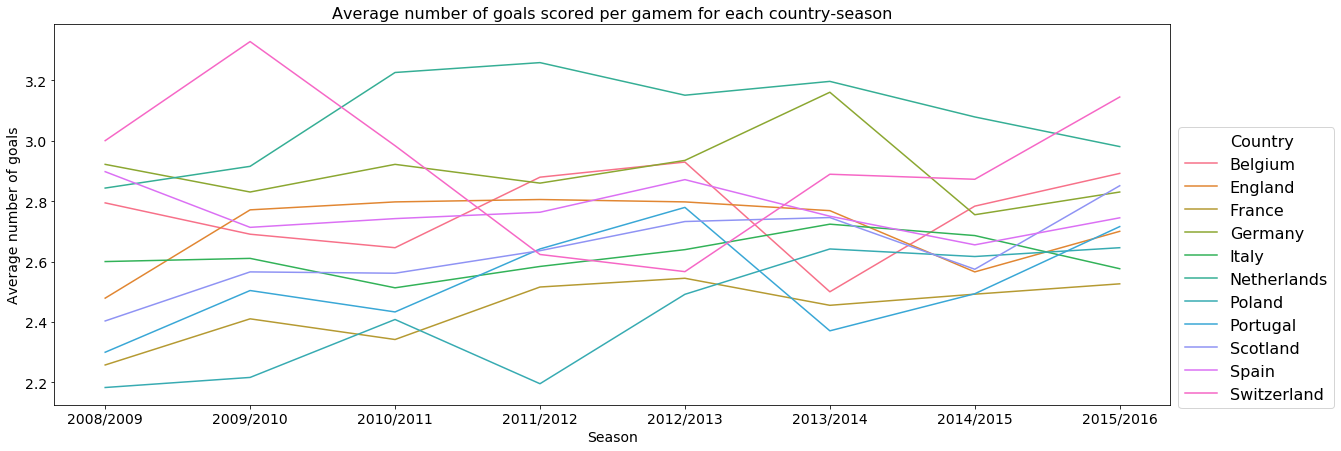

In [17]:
plt.figure(figsize=(20,7))
ax = sbn.lineplot(data = df, x='Season', y='Avg_goals_per_game', hue='Country')
ax.tick_params(labelsize = 14)
plt.title('Average number of goals scored per gamem for each country-season', size = 16)
plt.ylabel('Average number of goals', size = 14)
plt.xlabel('Season', size = 14)
ax.legend( bbox_to_anchor= (1,0.75), fontsize = 16)
plt.show()

**4.**

**a.** Create a new feature called good_season that takes the value 1 if the average number
scored per game in a given season is greater than 2.75

In [18]:
df['good_season'] = 0
df.loc[df['Avg_goals_per_game'] > 2.75, 'good_season'] = 1

**b.** Create a summary data frame that displays the number of “good seasons” for each country.

In [19]:
df.groupby(by = 'Country', axis = 0).aggregate('sum').drop(columns = 'Avg_goals_per_game')

,good_season
Country,
Belgium,5
England,5
France,0
Germany,8
Italy,0
Netherlands,8
Poland,0
Portugal,1
Scotland,1


We can observe that the France (*Ligue 1*), Italy (*Serie A*) and Poland (*Ekstraklasa*) are the league with the lower amount of `good seasons`. 
Results are in concordance with the [official data](https://www.worldfootball.net/) and also with general knowledge (Italian football is boring). 